In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import tensorflow and tensorflow_datasets
import tensorflow as tf
import tensorflow_datasets as tfds

# import random stuff that hopefully?? is going to be useful
import numpy as np
import random
import time
from matplotlib import pyplot as plt

In [0]:
# define hyperparameters
batch_size = 64
learning_rate = 0.0002
n_z_input = 100

# number of epochs and iterations per epoch
train_epoch = 40
iterations_per_epoch = 300

In [0]:
# takes in a series of graph_images ([#images, :, :, 0]) and plot them
# each image is displayed as a 50 by 50 pixel image
# where images are laid out in rows of 10 images and columns of 20
def display_graph(graph_images, title, shape=(10, 20), image_size=(50, 50)):
    fig = plt.figure(figsize=image_size) # define figure
    plt.title(title) # define title
    plt.axis('off') # remove axis
    for i in range(0, shape[0] * shape[1]):
        img = graph_images[i, :, :, :].astype(np.int32) # added this
        fig.add_subplot(shape[0], shape[1], i + 1)
        plt.axis('off')
        plt.imshow(img, cmap="gray")
    plt.show()

## Model

In [0]:
def resnet_block(input, features):
    out1 = tf.layers.conv2d(input, features, (3, 3), (1, 1), 'SAME')
    out2 = tf.layers.conv2d(out1, features, (3, 3), (1, 1), 'SAME')
    return out2 + input

In [0]:
# generator and discriminator 
def generator(features, name, reuse=False):
    with tf.variable_scope('generator' + name, reuse=reuse):
        conv1 = tf.layers.conv2d(features, 128, [4, 4], strides=(2, 2), activation=tf.nn.relu, padding="SAME")
        conv2 = tf.layers.conv2d(conv1, 256, [4, 4], strides=(2, 2), activation=tf.nn.relu, padding="SAME")
        conv3 = tf.layers.conv2d(conv2, 512, [4, 4], strides=(4, 4), activation=tf.nn.relu, padding="SAME")
        
        resnet1 = resnet_block(conv3, 512)
        resnet2 = resnet_block(resnet1, 512)
        resnet3 = resnet_block(resnet2, 512)
        resnet4 = resnet_block(resnet3, 512)
        resnet5 = resnet_block(resnet4, 512)

        # tf.layers.conv2d_transpose
        deconv1 = tf.layers.conv2d_transpose(resnet5, 512, [4, 4], strides=(4, 4), activation=tf.nn.relu, padding="SAME")
        deconv2 = tf.layers.conv2d_transpose(deconv1, 256, [4, 4], strides=(2, 2), activation=tf.nn.relu, padding="SAME")
        deconv3 = tf.layers.conv2d_transpose(deconv2, 128, [4, 4], strides=(2, 2), activation=tf.nn.relu, padding="SAME")
        deconv3 = tf.layers.conv2d_transpose(deconv2, 3, [4, 4], strides=(2, 2), activation=tf.nn.relu, padding="SAME")
        return tf.nn.tanh(deconv3)

In [0]:
def discriminator(features, name, reuse=False):
    with tf.variable_scope('discriminator' + name, reuse=reuse):
        conv2 = tf.layers.conv2d(features, 64, [4, 4], (2, 2), 'same', activation=tf.nn.leaky_relu)
        conv3 = tf.layers.conv2d(conv2, 128, [4, 4], (4, 4), 'same', activation=tf.nn.leaky_relu)
        conv4 = tf.layers.conv2d(conv3, 256, [4, 4], (1, 1), 'valid', activation=tf.nn.leaky_relu)
        flatten = tf.contrib.layers.flatten(conv4)
        logits = tf.layers.dense(flatten, 1)
        # use sigmoid to squash output into a probability
        output = tf.nn.sigmoid(logits) 
        
        return output, logits

## Placeholders

In [0]:
x1 = tf.placeholder(tf.float32, shape=(None, 256, 256, 3))
x2 = tf.placeholder(tf.float32, shape=(None, 256, 256, 3))
# z = tf.placeholder(tf.float32, shape=(None, 256, 256, 3)) # n_z_input))
# 3 was originally n_z_input and the 64s were 1s for z vector

In [0]:
# generator is generating an image (g is the fake image)
g1 = generator(x1, 'apple', reuse=tf.AUTO_REUSE)
g2 = generator(x2, 'orange', reuse=tf.AUTO_REUSE)
# discriminator is classifying real images 
# the first output is the probability and the second is the logits
# to feed into sigmoid_cross_entropy_with_logits
disc_real_1, disc_real_logits_1 = discriminator(x1, 'apple', reuse=tf.AUTO_REUSE)
disc_fake_1, disc_fake_logits_1 = discriminator(g1, 'apple', reuse=tf.AUTO_REUSE)

disc_real_2, disc_real_logits_2 = discriminator(x2, 'orange', reuse=tf.AUTO_REUSE)
disc_fake_2, disc_fake_logits_2 = discriminator(g2, 'orange', reuse=tf.AUTO_REUSE)

gen_121 = generator(g1, 'gen_121', reuse=tf.AUTO_REUSE)
gen_212 = generator(g2, 'gen_212', reuse=tf.AUTO_REUSE)


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.


Losses

In [0]:
# loss function for discriminator_1
disc_loss_real_1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_logits_1, labels=tf.ones([batch_size, 1]))
disc_loss_real_1 = tf.reduce_mean(disc_loss_real_1)

disc_loss_fake_1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits_1, labels=tf.zeros([batch_size, 1]))
disc_loss_fake_1 = tf.reduce_mean(disc_loss_fake_1)

disc_loss_total_1 = disc_loss_real_1 + disc_loss_fake_1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# loss function for discriminator_2
disc_loss_real_2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_logits_2, labels=tf.ones([batch_size, 1]))
disc_loss_real_2 = tf.reduce_mean(disc_loss_real_2)

disc_loss_fake_2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits_2, labels=tf.zeros([batch_size, 1]))
disc_loss_fake_2 = tf.reduce_mean(disc_loss_fake_2)
 
disc_loss_total_2 = disc_loss_real_2 + disc_loss_fake_2

In [0]:
# loss function for generator
gen_loss_1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits_1, labels=tf.ones([batch_size, 1]))
gen_loss_1 = tf.reduce_mean(gen_loss_1)

In [0]:
# loss function for generator_2
gen_loss_2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits_2, labels=tf.ones([batch_size, 1]))
gen_loss_2 = tf.reduce_mean(gen_loss_2)

In [0]:
#cycle loss
cycle_loss = (tf.reduce_mean(tf.abs(x1 - gen_121)) + tf.reduce_mean(tf.abs(x2 - gen_212)))

In [0]:
t_vars = tf.trainable_variables()
disc_var_1 = [var for var in t_vars if var.name.startswith('discriminatorapple')]
gen_var_1 = [var for var in t_vars if var.name.startswith('generatorapple')]

disc_var_2 = [var for var in t_vars if var.name.startswith('discriminatororange')] # HAVE TO CHANGE SOMETHING STILL

gen_var_2 = [var for var in t_vars if var.name.startswith('generatororange')]

Adam Optimizer

In [0]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    gen_optimizer_1 = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(gen_loss_1, var_list=gen_var_1)
    disc_optimizer_1 = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(disc_loss_total_1, var_list=disc_var_1)
    gen_optimizer_2 = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(gen_loss_2, var_list=gen_var_2)
    disc_optimizer_2 = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(disc_loss_total_2, var_list=disc_var_2)
    #real_fake_loss = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(## (real_apple - fake_apple)^2)

Load Data

In [0]:
datasets, metadata = tfds.load('cycle_gan/apple2orange', with_info=True, as_supervised=True)

In [0]:
apple_train_dataset, orange_train_dataset, apple_test_dataset, orange_test_dataset = datasets["trainA"], datasets["trainB"], datasets["testA"], datasets["testB"]

In [0]:
def apply_map(inputs, foo):
    print(foo)
    img = inputs
    # 1. cast the img into float32
    img = tf.cast(img, tf.float32)
    img = tf.subtract(img, 0.5)
    img = tf.divide(img, 0.5)
    # 2. image values are from 0 to 1. convert to range -1 to 1
    # by subtracting by a decimal so its range -0.5 to 0.5 and
    # then divide by a decimal so its not -1 to 1
    # img = tf.math.tanh(img)
    # 3. use tf.image.resize to convert the image into a 64 by 64 image
    img = tf.image.resize(img, [256, 256])
    return img #tanh???

In [0]:
apple_train_dataset = apple_train_dataset.map(apply_map)
apple_train_dataset = apple_train_dataset.shuffle(1024)
apple_train_dataset = apple_train_dataset.batch(batch_size)

apple_iterator = apple_train_dataset.make_initializable_iterator()
apple_batch = apple_iterator.get_next()

orange_train_dataset = orange_train_dataset.map(apply_map)
orange_train_dataset = orange_train_dataset.shuffle(1024)
orange_train_dataset = orange_train_dataset.batch(batch_size)

orange_iterator = orange_train_dataset.make_initializable_iterator()
orange_batch = orange_iterator.get_next()

Tensor("args_1:0", shape=(), dtype=int64)
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Tensor("args_1:0", shape=(), dtype=int64)


In [0]:
# z_test input into the generator with batch_size 10 
z_test = np.random.normal(0, 1, (10, 1, 1, n_z_input))

Starting epoch: 0


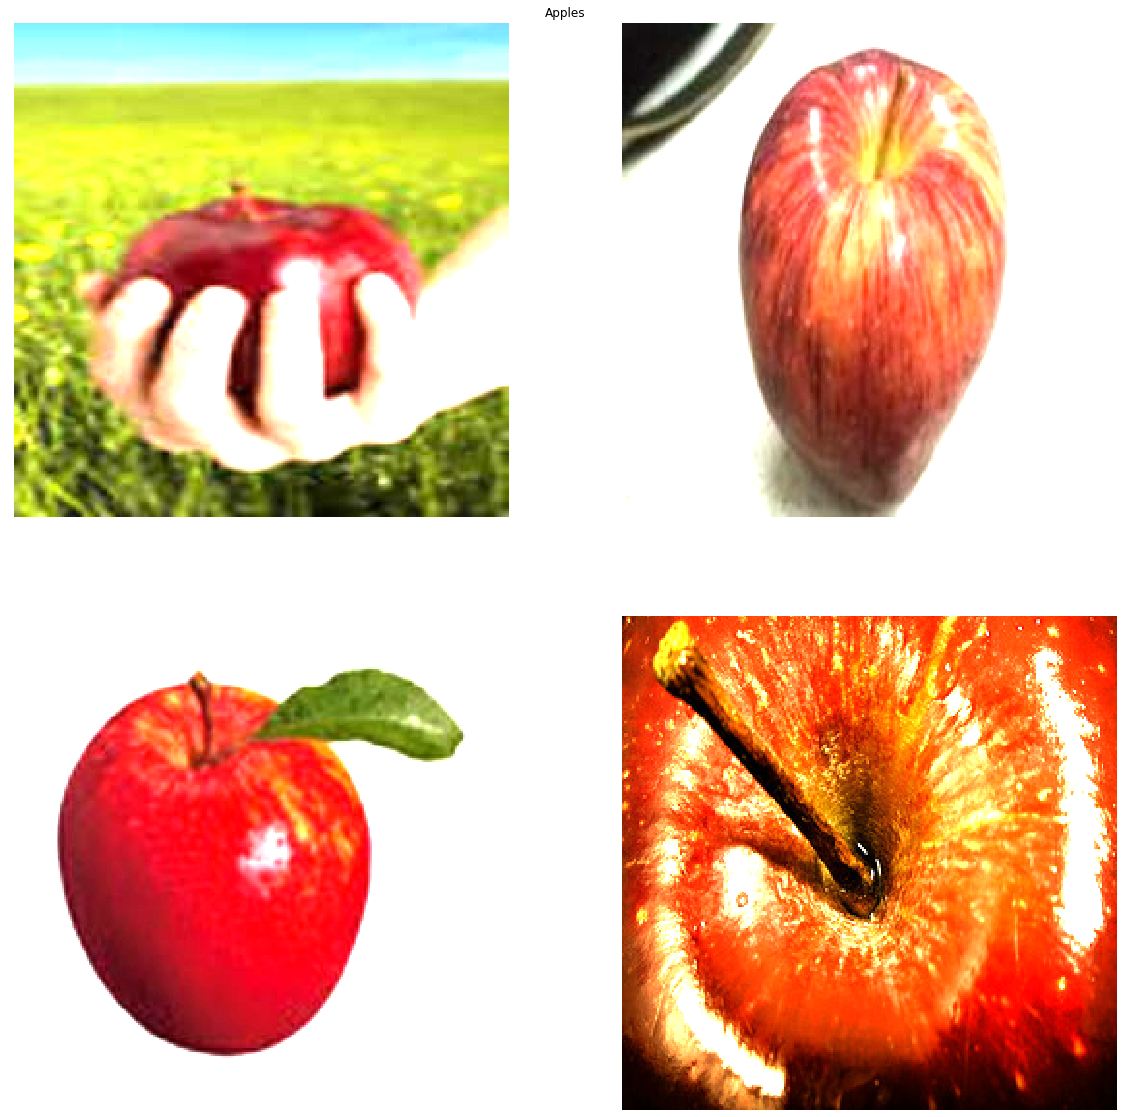

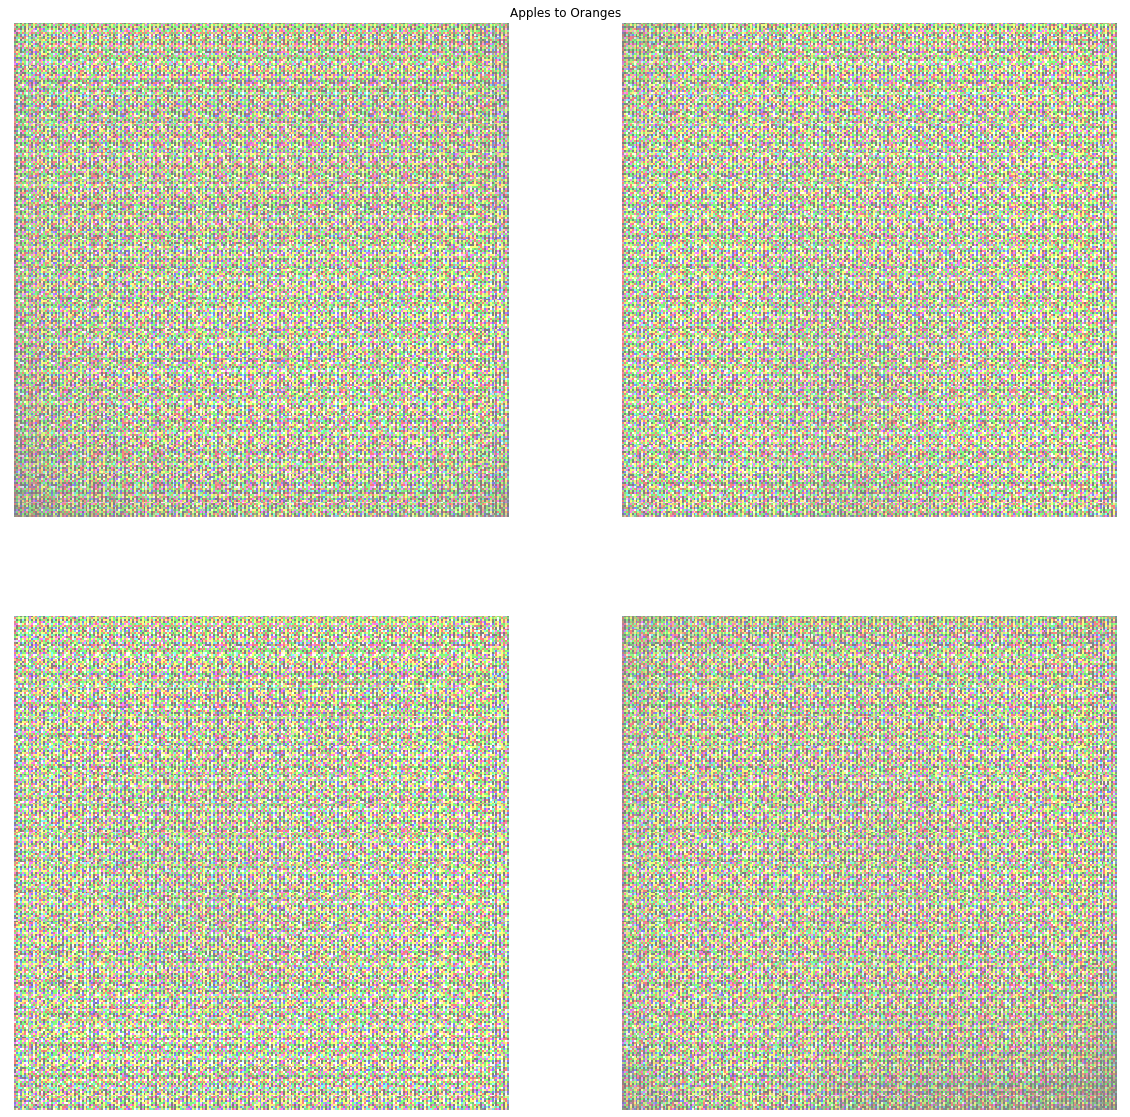

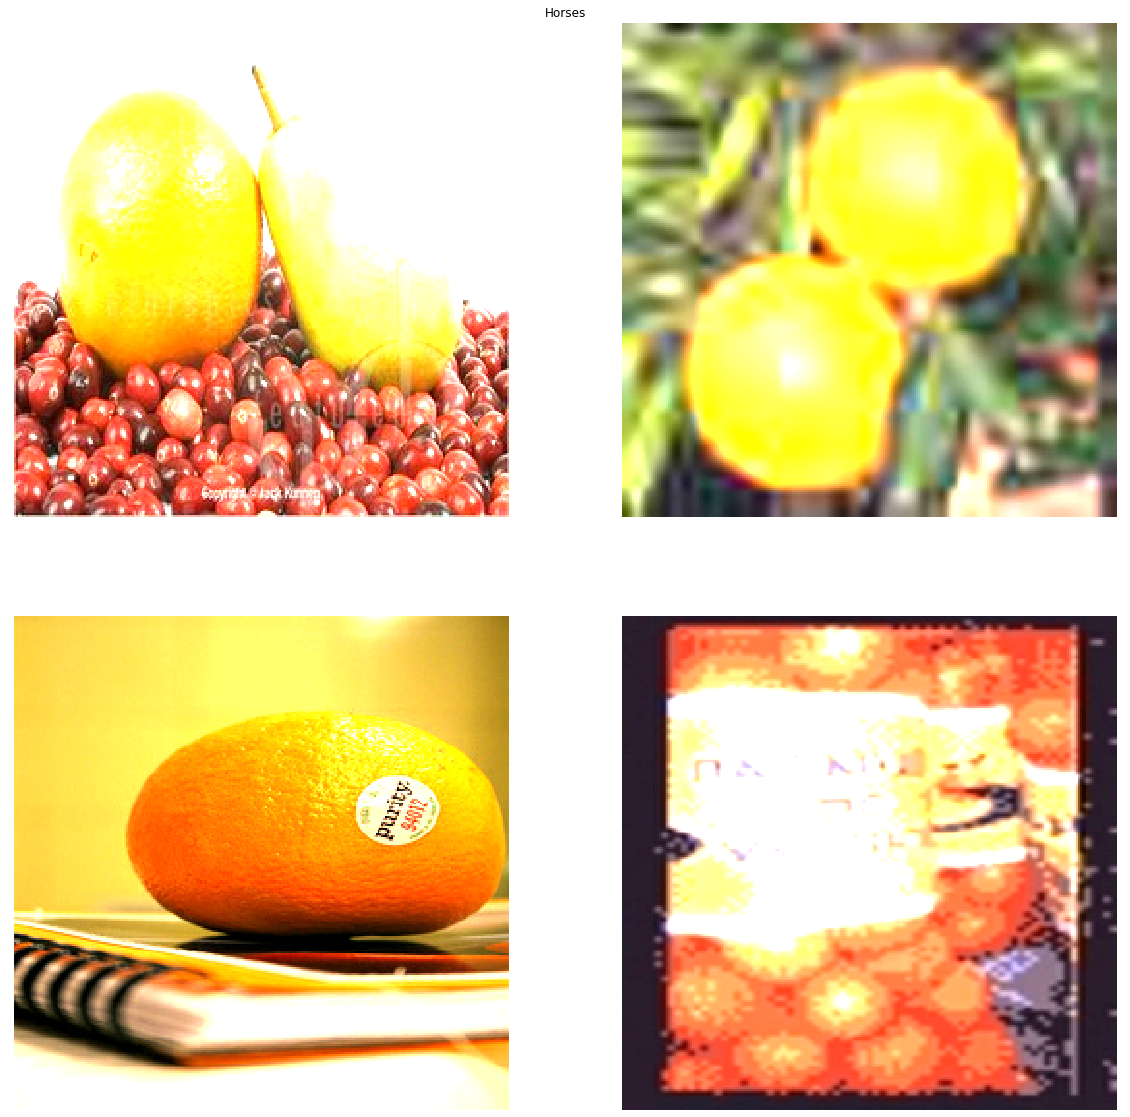

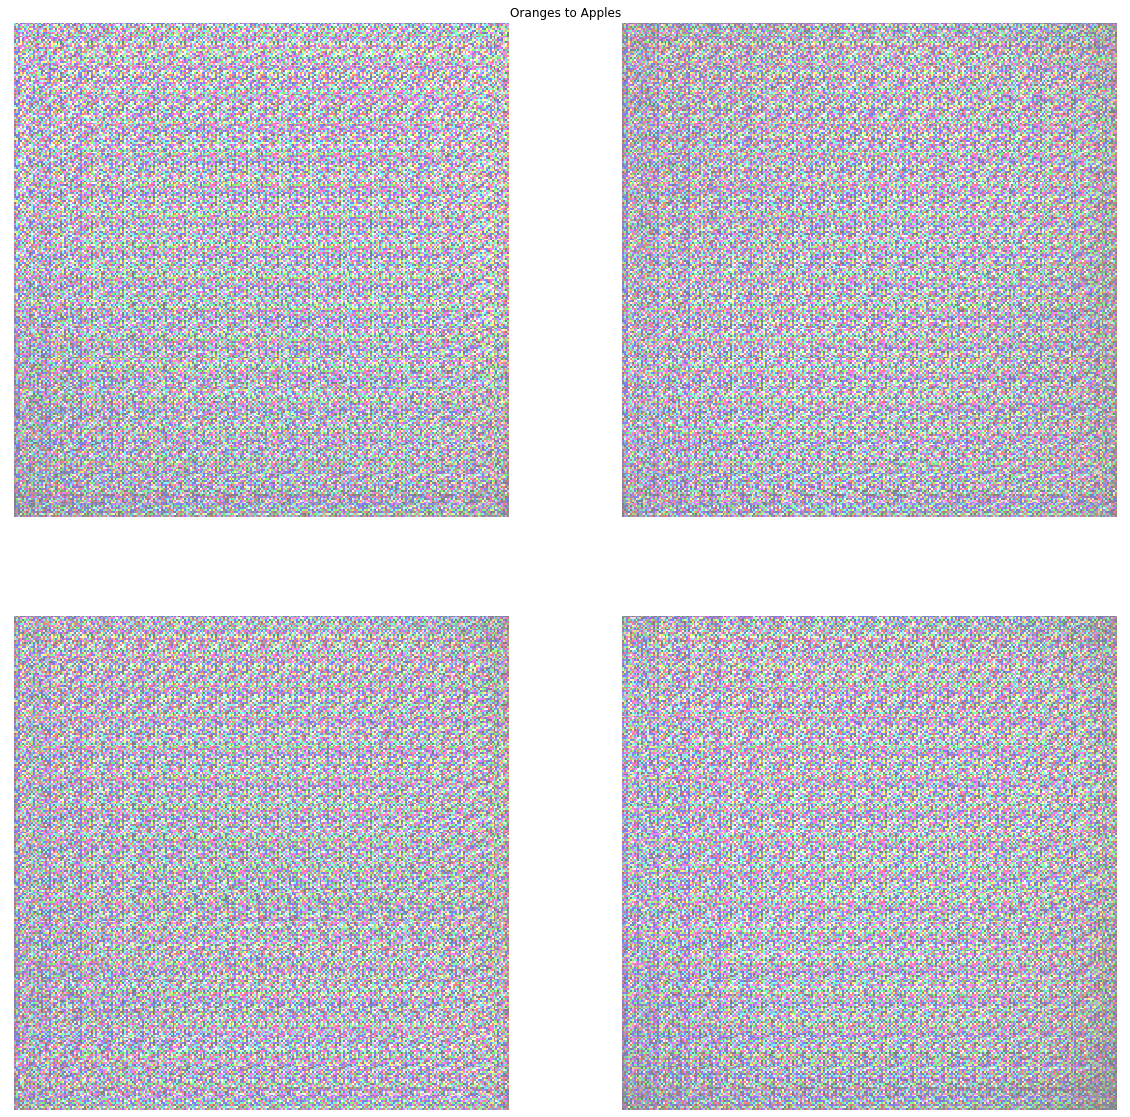

Disc_1_Loss Tensor("add:0", shape=(), dtype=float32)


TypeError: ignored

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(train_epoch):
        print("Starting epoch: " + str(epoch))
        # initialize iterator
        sess.run(apple_iterator.initializer)
        sess.run(orange_iterator.initializer)
        step = 0
        count = 0

        while True:
            try:
                # tra_images = sess.run(batch) # grab the batch
                apple = sess.run(apple_batch)
                orange = sess.run(orange_batch)
                # makes sure the batch_size is correct
                if apple.shape[0] != orange.shape[0] or orange.shape[0] != batch_size:
                    break
                if(epoch % 4 == 0):
                    apple_to_orange, orange_to_apple = sess.run([g1, g2], feed_dict={x1:apple, x2:orange})
                    display_graph(apple, "Apples", (2, 2), image_size=(20, 20))
                    display_graph(255*(apple_to_orange+1)/2, "Apples to Oranges", (2, 2), image_size=(20, 20))
                    display_graph(orange, "Horses", (2, 2), image_size=(20, 20))
                    display_graph(255*(orange_to_apple+1)/2, "Oranges to Apples", (2, 2), image_size=(20, 20))
                    print("Disc_1_Loss", disc_loss_total_1)
                    print("Disc_2_Loss", + disc_loss_total_2)
                    print("Gen_1_Loss", gen_loss_1)
                    print("Gen_2_Loss", gen_loss_2)
                if(count % 10 == 0):
                    print("Batch", count*10)
                count += 1   
                # z vector of size batch_size
                # z_batch = np.random.normal(0, 1, (batch_size, 1, 1, n_z_input))
                sess.run([disc_optimizer_1, disc_optimizer_2, gen_optimizer_1, gen_optimizer_2],
                   feed_dict={x1:apple, x2: orange})

                # # CHANGE THIS ONE
                # acc_fake, acc_real, loss_d, _, loss_g, _ = sess.run(
                #   [fake_accuracy, real_accuracy, disc_loss_total, disc_optimizer, gen_loss, gen_optimizer],
                #   feed_dict={x: tra_images, z: z_batch})
                # step += 1

            except tf.errors.OutOfRangeError:
                break